In [95]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import math
import numpy as np
import explore as ex
import preprocess as pp
import getfeatures as gf
import evalmodel as em
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1) Read in Data

First, we read the data csv file into a Pandas Dataframe:

In [142]:
data = ex.read_data("data/credit-data.csv")

# 2) Explore Data

We then explore the data by examining the distribution of all of the variables in our dataframe by producing a distribution table and histograms plotting the distribution of each variable:

In [143]:
ex.dist_table(data)

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,41016.000000,41016.000000,41016.00000,41016.000000,41016.000000,41016.000000,41016.000000,3.304200e+04,41016.000000,41016.000000,41016.000000,41016.000000,39979.000000
mean,115800.154598,0.161400,6.37587,51.683489,60623.824166,0.589233,331.458137,6.578996e+03,8.403477,0.419592,1.008801,0.371587,0.773231
std,28112.723511,0.367904,221.61895,14.746880,11.984357,5.205628,1296.109695,1.344683e+04,5.207324,5.190382,1.153826,5.169641,1.121269
min,22.000000,0.000000,0.00000,21.000000,60601.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106539.750000,0.000000,0.03431,41.000000,60618.000000,0.000000,0.176375,3.333000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,119901.500000,0.000000,0.18973,51.000000,60625.000000,0.000000,0.369736,5.250000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,134698.250000,0.000000,0.66716,62.000000,60629.000000,0.000000,0.866471,8.055750e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,149999.000000,1.000000,22000.00000,109.000000,60644.000000,98.000000,106885.000000,1.794060e+06,56.000000,98.000000,32.000000,98.000000,13.000000


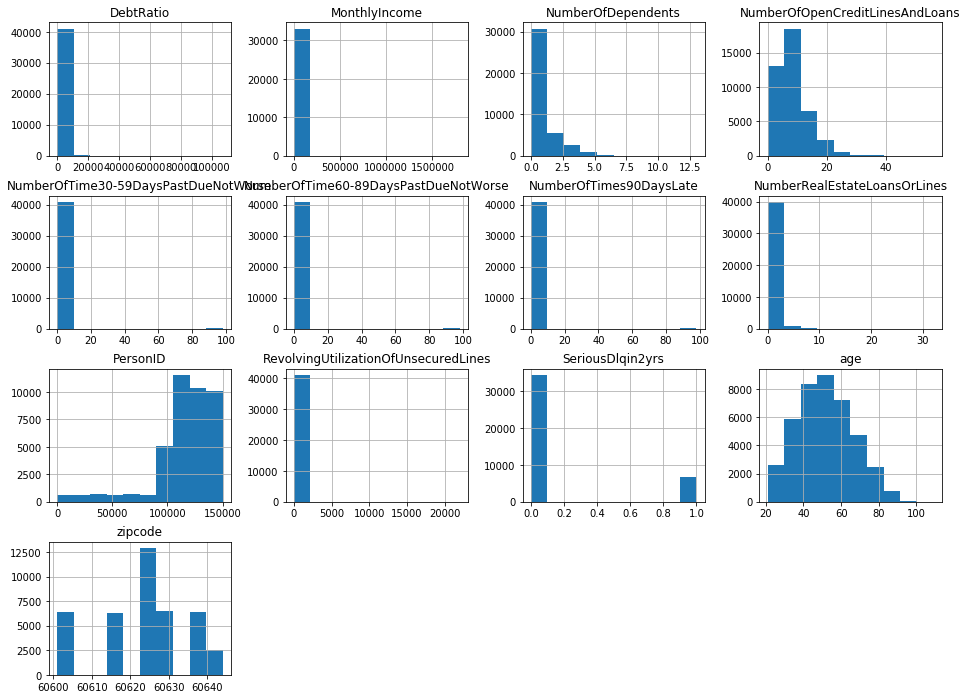

In [144]:
ex.dist_plot(data)

We then plot each variable subset by the label value (in our case, whether SeriousDlqin2yrs = 0 or = 1) to assess whether the distribution of the factors varies given the value of the label. We can see that, while all the variables follow similar distributions for each value of the label, there are some visually apparent distinctions in the distribution of the factors by label value. By a simple visual examination of the data, we can see that, PersonID is significantly higher for those who do not experience financial destress than those who do, the average age of those who experience financial distress is lower than those who do not, and the number of open credit lines and loans seems to be lower for those who experience financial distress than those who do not.

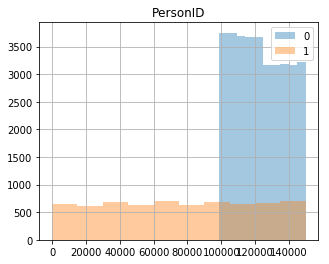

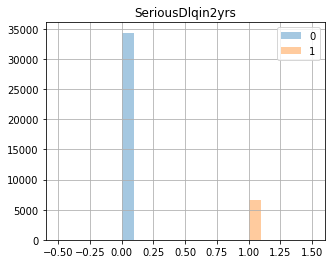

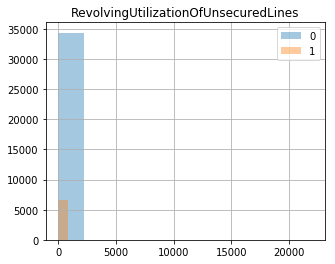

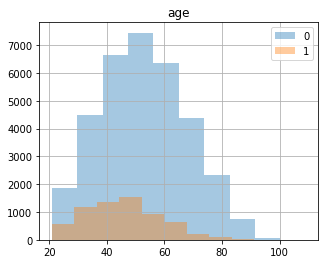

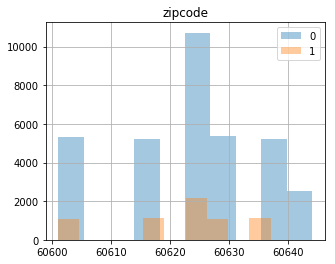

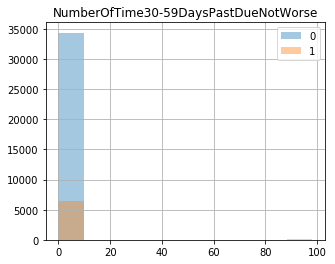

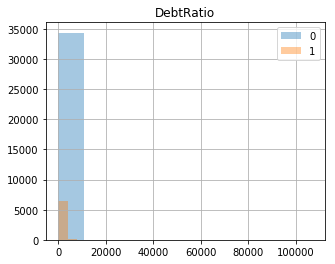

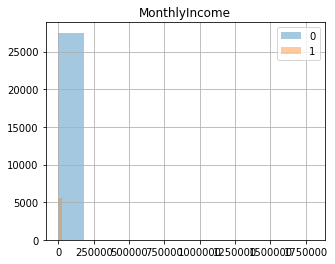

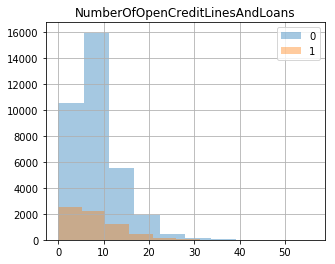

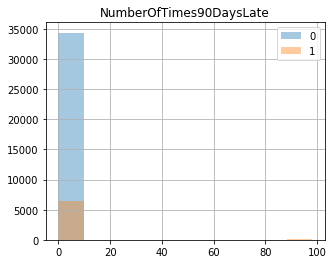

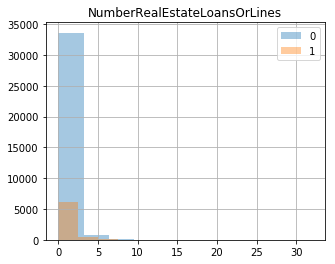

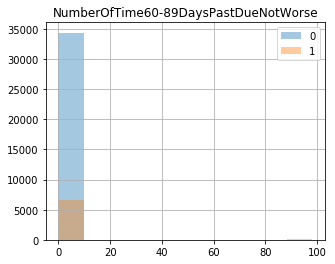

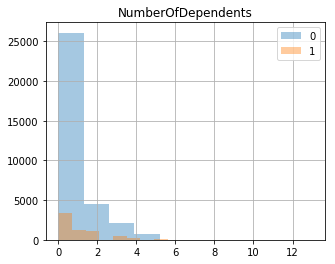

In [145]:
ex.plot_by_class(data, "SeriousDlqin2yrs")

We then investigate the correlations between each of the variables in our dataframe by producing a plot that shows the correlation of each variable with the dependent variable (as a test of relevance for our analysis) as well as a plot that shows the correlation between all pairs of variables in our dataframe to identify collinearity (to avoid including highly collinear variables that will therefore produce undue weight for one phenomenon in our distance calculation):

In [148]:
corr_table = ex.corr_table(data)

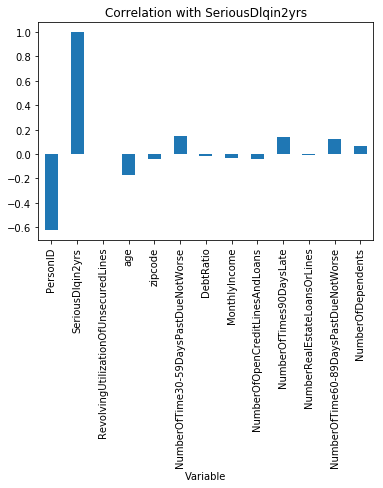

In [7]:
ex.plot_y_corr(corr_table, "SeriousDlqin2yrs")

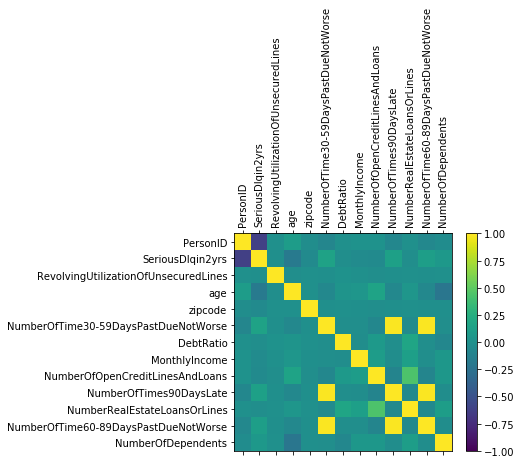

In [149]:
ex.plot_corr_matrix(corr_table)

We find above that PersonID is highly correlated with our dependent variable and that the variables measuring the number of times 30-59 days past due, 60-89 days past due, and more than 90 days late are highly collinear, which makes sense as the 60-89 variable is a subset of the 30-59 and the 90+ variable is a subset of both variables. 

We then plot the data to identify the presence of outliers in our variables below:

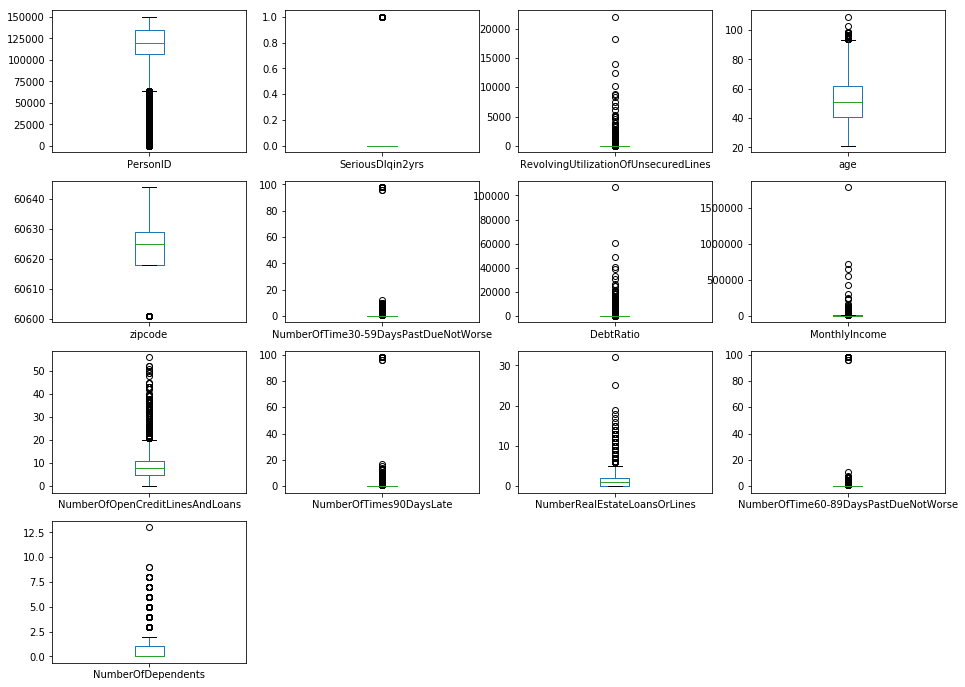

In [17]:
ex.outliers_plot(data)

Based on the exploratory data findings, I conclude the following:
* We see that *PersonID* is strongly negatively correlated with the outcome variable in the correlation matrix above, yet should be a random number that is not related to the outcome. Therefore, we will drop this variable to ensure that it does not bias our results. 
* We see that the variables *Number of Times 30-59 Days Past Due*, *Number of Times 60-89 Days Past Due*, and *Number of Times 90 Days Late* are highly collinear in the correlation matrix above. Therefore, including all three of these variables in a k-nearest neighbor model will give the variable of "lateness" undue weight in identifying the nearest neighbor. Therefore, we will only include one of these variables in our model, in this case Number of Times 30-59 Days Past Due as that variable is a super set of the other two. 
* We also see that *Revolving Utilization of Unsecured Lines* has extremely weak correlation with the outcome variable, with a correlation coefficient of -0.004586 per the correlation table we produced. We will therefore drop this variable from our analysis to avoid an irrellevant variable influencing the nearest neighbor calculations.

In addition, we also see in the outlier plots above that many of our remaining variables have significant outliers that we will need to address in the data pre-processing step by producing discretized varibles for our continuous variables that have significant outliers.

# 3) Pre-Process and Clean Data

We then pre-process the data by filling in missing values in the dataset. We impute these values using the median of the given column. We choose median as our measure of central tendency because it is less sensitive to outlier values than the mean, and we saw above that several of our variables have significant outliers/long tail distributions.

In [118]:
data = pp.fill_missing_median(data)

In [33]:
data.median()

PersonID                                119901.500000
SeriousDlqin2yrs                             0.000000
RevolvingUtilizationOfUnsecuredLines         0.189730
age                                         51.000000
zipcode                                  60625.000000
NumberOfTime30-59DaysPastDueNotWorse         0.000000
DebtRatio                                    0.369736
MonthlyIncome                             5250.000000
NumberOfOpenCreditLinesAndLoans              8.000000
NumberOfTimes90DaysLate                      0.000000
NumberRealEstateLoansOrLines                 1.000000
NumberOfTime60-89DaysPastDueNotWorse         0.000000
NumberOfDependents                           0.000000
dtype: float64

# 4) Generate Features

We then generate features for inclusion in our analysis. We discretize the variables age and monthly income because we saw in the exploratory step that both of these variables have significant outliers. For age, we use evenly spaced bins while for monthly income we use percentile bins because to avoid having the extreme outlier value of $1,794,060 skew the distribution of our bins, resulting in nearly all of our data points in the lower bin values. We also generate dummy variables for the variable of number of real estate loans or lines.

In [119]:
data, bins = gf.discretize(data, "age")
bins

array([  20.912,   29.8  ,   38.6  ,   47.4  ,   56.2  ,   65.   ,
         73.8  ,   82.6  ,   91.4  ,  100.2  ,  109.   ])

In [120]:
bin_sep = data.MonthlyIncome.quantile([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

data, bins = gf.discretize(data, "MonthlyIncome", num_bins = bin_sep)
bins

array([       0.,     2267.,     3330.,     4230.,     5216.,     5250.,
           5300.,     6500.,     8094.,    10583.,  1794060.])

In [124]:
data = gf.cat_to_dummy(data, "NumberRealEstateLoansOrLines")

# 5 & 6) Build/Evaluate Classifier

For this assignment, I will use the k-Nearest Neighbors classifier. I first generate a training and testing sets for our model, dropping the variables identified in the exploratory phase and the variables for which we created discretized/dummy variables in the previous step.

In [150]:
people = data['PersonID'] 
X = pp.drop_vars(data, ["PersonID", "age", "MonthlyIncome", "NumberRealEstateLoansOrLines", "SeriousDlqin2yrs","RevolvingUtilizationOfUnsecuredLines", "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse"])
Y = data['SeriousDlqin2yrs']
test_size = 0.3 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

To identify the best model for predicting who will experience financial distress in the next two years, I train a number of different KNN classifiers by varying the number of neighbors, metric, and weights parameters of the KNN classifier function in sklearn to identify which model yields the highest accuracy. I produce a table that holds the results of each model tested.

In [134]:
n_neighbors = [1, 5, 10, 20, 30, 50, 100]
metric = ["euclidean", "manhattan", "chebyshev", "minkowski"]
weight = ["uniform", "distance"]
eval_table = em.knn_eval_table(y_test, x_test, x_train, y_train, n_neighbors, metric, weight)

The best performing model is the k-nearest neighbors model with number of neighbors = 30, metric = "chebyshev" and weight = "uniform" with an accuracy of 0.84. However, it is important to evaluate the quality of this accuracy result in context. As we saw in the exploratory phase, 16.14% of our sample experienced financial distress within 2 years (which is equivalent to saying 83.86% did not experience financial distress). Therefore, this model only performs slightly better than a model that assigns all observations a predicted outcome of 0 (no financial distress). Therefore, further analysis is warranted to identify a better performing model.

In [130]:
eval_table.loc[eval_table['accuracy'].idxmax()]

n_neighbors           30
metric         chebyshev
weight           uniform
accuracy        0.842503
Name: 36, dtype: object